### Install necessary packages

In [1]:
!pip install reportlab
!pip install wfdb
!pip install optuna
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 957.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 9.4 MB/s eta 0:00:00


### Download AFDB

In [2]:
!unzip /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip # Download PhysioNet Afdb

Archive:  /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip
   creating: files/
   creating: files/old/
  inflating: files/08455.hea         
  inflating: files/08215.dat         
  inflating: files/04908.atr         
  inflating: files/07162.hea-        
  inflating: files/08219.atr         
  inflating: files/08219.hea-        
  inflating: files/08434.hea-        
  inflating: files/00735.hea         
  inflating: files/05121.dat         
  inflating: files/07910.dat         
  inflating: files/04746.hea-        
  inflating: files/04746.atr         
  inflating: files/08378.dat         
  inflating: files/05261.hea-        
  inflating: files/SHA256SUMS.txt    
  inflating: files/04048.hea-        
  inflating: files/04936.xws         
  inflating: files/04936.dat         
  inflating: files/07879.qrs         
  inflating: files/05121.atr         
  inflating: files/08455.dat         
  inflating: files/04936.atr         
  inflating: files/05121.qrs         
  

### Preprocess


In [4]:
import wfdb
import neurokit2 as nk
import pandas as pd
import numpy as np
import os

def add_has_afib_column(df):
    # Create the has_AFIB column based on num_AFIB_annotations
    df['has_AFIB'] = (df['num_AFIB_annotations'] > 0).astype(int)
    return df

def load_and_combine_data(data_dir, output_file):
    # Initialize an empty list to hold DataFrames
    data_frames = []

    # Iterate over all files in the data directory
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(data_dir, file_name)
            print(f"Reading file: {file_path}")
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            print(f"File {file_name} contains {len(df)} records")
            print(df.head())  # Print the first few records for verification
            data_frames.append(df)

    # Combine all DataFrames into one
    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        combined_df = add_has_afib_column(combined_df)

        print(f"Combined DataFrame contains {len(combined_df)} records")
        print(combined_df.head())  # Print the first few records of the combined DataFrame

        # Save the combined DataFrame to a new CSV file
        combined_df.to_csv(output_file, index=False)

        # Re-read the saved file to verify the save operation
        saved_df = pd.read_csv(output_file)
        print(f"Re-read combined data saved to {output_file}")
        print(f"Total records in re-read combined file: {len(saved_df)}")
        print(saved_df.head())  # Print the first few records of the re-read combined DataFrame
    else:
        print("No CSV files found in the directory.")

def calculate_pr_interval(info, sampling_rate):
  p_peaks = info["ECG_P_Peaks"]
  r_peaks = info["ECG_R_Peaks"]
  pr_intervals = []
  for p_peak, r_peak in zip(p_peaks, r_peaks):
      if not np.isnan(p_peak) and not np.isnan(r_peak):
          pr_interval = ((r_peak - p_peak) / sampling_rate) * 1000
          pr_intervals.append(pr_interval)
  pr_interval_mean = np.mean(pr_intervals) if pr_intervals else 0
  pr_interval_std = np.std(pr_intervals) if pr_intervals else 0
  return pr_interval_mean, pr_interval_std

def calculate_qrs_duration(info, sampling_rate):
  q_peaks = info["ECG_Q_Peaks"]
  r_onsets = info["ECG_R_Onsets"]
  s_peaks = info["ECG_S_Peaks"]
  qrs_durations = []
  for i in range(min(len(q_peaks), len(s_peaks))):
      if not np.isnan(q_peaks[i]) and not np.isnan(r_onsets[i]) and not np.isnan(s_peaks[i]):
          nearest_q_onset = min(q_peaks[i], r_onsets[i])
          qrs_duration = ((s_peaks[i] - nearest_q_onset) / sampling_rate) * 1000
          qrs_durations.append(qrs_duration)
  qrs_duration_mean = np.mean(qrs_durations) if qrs_durations else 0
  qrs_duration_std = np.std(qrs_durations) if qrs_durations else 0
  return qrs_duration_mean, qrs_duration_std


def calculate_qt_interval(info, sampling_rate):
  q_peaks = info["ECG_Q_Peaks"]
  t_offsets = info["ECG_T_Offsets"]
  qt_intervals = []
  for i in range(min(len(q_peaks), len(t_offsets))):
      if not np.isnan(q_peaks[i]) and not np.isnan(t_offsets[i]):
          nearest_q_peak = min(q_peaks[i], t_offsets[i])
          qt_interval = ((t_offsets[i] - nearest_q_peak) / sampling_rate) * 1000
          qt_intervals.append(qt_interval)
  qt_interval_mean = np.mean(qt_intervals) if qt_intervals else 0
  qt_interval_std = np.std(qt_intervals) if qt_intervals else 0
  return qt_interval_mean, qt_interval_std


def calculate_poincare(rr_intervals):
  rr_n = rr_intervals[:-1]
  rr_n1 = rr_intervals[1:]
  sd1 = np.std(np.subtract(rr_n1, rr_n) / np.sqrt(2))
  sd2 = np.std(np.add(rr_n1, rr_n) / np.sqrt(2))
  return sd1, sd2

def process_ecg_interval(record_path, record_name, start_sample, end_sample, interval_index):
  global total_N_annotations
  global total_AFIB_annotations
  global last_annotation
  global last_annotation_type

  # Read the header of the record to get metadata
  record_header = wfdb.rdheader(record_path)
  total_samples = record_header.sig_len

  # Ensure that end_sample does not exceed the total length of the signal
  end_sample = min(end_sample, total_samples)

  if end_sample - start_sample < 10:  # Ensure the interval has at least 10 samples
      print(f"Error processing interval {interval_index}: The data length is too small to be segmented.")
      return None

  record_segment = wfdb.rdrecord(record_path, sampfrom=start_sample, sampto=end_sample)
  ecg_signal = record_segment.p_signal[:, 0]  # Assuming the first channel is ECG
  sampling_rate = record_segment.fs

  # Read the annotations (if they exist)
  try:
      annotations = wfdb.rdann(record_path, 'atr', sampfrom=start_sample, sampto=end_sample)
      print("atr annotations")
      print(annotations)
      print("sample" + str(annotations.sample))
      print("symbol" + str(annotations.symbol) + str(annotations.subtype))
      print("aux_note" + str(annotations.aux_note))
      print("")
  except FileNotFoundError:
      annotations = None

  try:
      qrs_annotations = wfdb.rdann(record_path, 'qrs', sampfrom=start_sample, sampto=end_sample)
  except FileNotFoundError:
      qrs_annotations = None

  # Process the ECG signal
  try:
      ecg_signals, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)
  except Exception as e:
      print(f"Error processing interval {interval_index}: {e}")
      return None

  # Extract relevant features
  heart_rate = ecg_signals["ECG_Rate"]
  signal_quality = ecg_signals["ECG_Quality"]
  avg_quality = np.mean(signal_quality)
  r_peaks = info["ECG_R_Peaks"]
  hrv_time = nk.hrv_time(r_peaks, sampling_rate=sampling_rate)

  # Calculate intervals using helper functions
  pr_interval_mean, pr_interval_std = calculate_pr_interval(info, sampling_rate)
  qrs_duration_mean, qrs_duration_std = calculate_qrs_duration(info, sampling_rate)
  qt_interval_mean, qt_interval_std = calculate_qt_interval(info, sampling_rate)

  # Calculate Coefficient of Variation (CV)
  rr_intervals = np.diff(r_peaks) / sampling_rate * 1000  # Convert to milliseconds
  cv = hrv_time["HRV_SDNN"].iloc[0] / hrv_time["HRV_MeanNN"].iloc[0]

  # Poincare Plot Analysis
  sd1, sd2 = calculate_poincare(rr_intervals)

  # Prepare a dictionary of extracted features
  features = {
      "record_name": record_name,
      "start_time": interval_index / 6,  # in minutes
      "sampling_rate": sampling_rate,
      "heart_rate_mean": heart_rate.mean(),
      "heart_rate_std": heart_rate.std(),
      "signal_quality": avg_quality,  # see explanation below
      "pr_interval_mean": pr_interval_mean,  # all values for intervals are in milliseconds
      "pr_interval_std": pr_interval_std,
      "qrs_duration_mean": qrs_duration_mean,
      "qrs_duration_std": qrs_duration_std,
      "qt_interval_mean": qt_interval_mean,
      "qt_interval_std": qt_interval_std,
      "hrv_rmssd": hrv_time["HRV_RMSSD"].iloc[0],
      # Square root of the mean of the squared successive differences between adjacent RR intervals.
      "hrv_mean": hrv_time["HRV_MeanNN"].iloc[0],  # The mean of the RR intervals in milliseconds
      "hrv_sdnn": hrv_time["HRV_SDNN"].iloc[0],  # The standard deviation of the RR intervals in milliseconds
      "cv": cv,
      # Coefficient of Variation (CV) the ratio of the standard deviation of the RR intervals to the mean RR interval.
      "sd1": sd1,  # Coordinates for scatter plots where each RR interval is plotted against the previous RR interval.
      "sd2": sd2,
      # signal_quality:
      # it is a value from 0 to 1:
      # 1 corresponds to heartbeats that are the closest to the average sample
      # 0 corresponds to the most distant heartbeat from that average sample.
  }

  # Add annotation-related features
  if annotations is not None:
      features["num_annotations"] = len(annotations.sample)

      # Count annotations and update total counts
      num_N_annotations = 0
      num_AFIB_annotations = 0
      aux_notes = annotations.aux_note
      if aux_notes:
          for note in aux_notes:
              if note == '(N':
                  num_N_annotations = 1
                  num_AFIB_annotations = 0
                  total_N_annotations += 1
                  last_annotation = 'N'
              elif note == '(AFIB':
                  num_N_annotations = 0
                  num_AFIB_annotations = 1
                  total_AFIB_annotations += 1
                  last_annotation = 'AFIB'

      features["num_N_annotations"] = num_N_annotations
      features["num_AFIB_annotations"] = num_AFIB_annotations
      features["total_N_annotations"] = total_N_annotations
      features["total_AFIB_annotations"] = total_AFIB_annotations
  else:
      features["num_annotations"] = 1
      features["num_AFIB_annotations"] = 1
      features["total_AFIB_annotations"] = 1
      features["num_N_annotations"] = 0
      features["total_N_annotations"] = 0

  # Update the annotation values based on the last detected annotation
  if last_annotation == 'N':
      features["num_N_annotations"] = 1
      features["num_AFIB_annotations"] = 0
  elif last_annotation == 'AFIB':
      features["num_N_annotations"] = 0
      features["num_AFIB_annotations"] = 1

  if qrs_annotations is not None:
      features["num_qrs_annotations"] = len(qrs_annotations.sample)
  else:
      features["num_qrs_annotations"] = 0

  return features

# 10 seconds intervals
def process_ecg_record(record_path, record_name):
  # Read the header of the record to get metadata
  record = wfdb.rdheader(record_path)
  sampling_rate = record.fs
  total_samples = record.sig_len

  # Split the signal into 10 second intervals
  ten_sec_intervals = sampling_rate * 10

  # Calculate the number of intervals needed to cover the entire signal
  num_intervals = total_samples // ten_sec_intervals
  if total_samples % ten_sec_intervals != 0:
      num_intervals += 1  # Add one more interval for the remaining samples
  all_features = []

  for i in range(num_intervals):
      start_sample = i * ten_sec_intervals
      end_sample = start_sample + ten_sec_intervals
      try:
          features = process_ecg_interval(record_path, record_name, start_sample, end_sample, i)
          if features is not None:
              all_features.append(features)
      except Exception as e:
          print(f"Error processing interval {i}: {e}")

  return all_features

In [6]:
intervals_directory_path = "/content/data/10_sec_intervals"
preprocessed_data_directory_path = "/content/data/preprocessed_data"

if not os.path.exists(intervals_directory_path):
  # Create the directory and any missing intermediate directories
  os.makedirs(intervals_directory_path)
  print(f"Directory '{intervals_directory_path}' created.")
else:
  print(f"Directory '{intervals_directory_path}' already exists.")

if not os.path.exists(preprocessed_data_directory_path):
  # Create the directory and any missing intermediate directories
  os.makedirs(preprocessed_data_directory_path)
  print(f"Directory '{preprocessed_data_directory_path}' created.")
else:
  print(f"Directory '{preprocessed_data_directory_path}' already exists.")

total_N_annotations = 0
total_AFIB_annotations = 0
last_annotation = None
last_annotation_type = None

ptb_dir = "/content/files"
records = ["4043",
           "4048",
           "4126",
           "4746",
           "4908",
           "4936",
           "5091",
           "5121",
           "5261",
           "6426",
           "6453",
           "6995",
           "7162",
           "7859",
           "7879",
           "7910",
           "8215",
           "8219",
           "8378",
           "8405",
           "8434",
           "8455"]  # add records here

for record_name in records:
  record_path = os.path.join(ptb_dir, record_name)
  features = process_ecg_record(record_path, record_name)

  # Convert the list of dictionaries to a DataFrame
  df = pd.DataFrame(features)
  file_name = intervals_directory_path + "/" + record_name + "_features.csv"

  # Save the DataFrame to a CSV file
  df.to_csv(file_name, index=False)

output_file = preprocessed_data_directory_path + "/afdb_data.csv"

load_and_combine_data(intervals_directory_path, output_file)

Streaming output truncated to the last 5000 lines.
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


Streaming output truncated to the last 5000 lines.
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3519: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3520: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3523: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3526: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3527: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3530: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3531: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3535: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3538: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3541: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3542: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3543: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3545: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3546: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3548: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3549: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3551: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3552: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3553: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3554: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3559: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3560: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3564: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3565: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3568: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3574: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3576: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3577: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3588: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3589: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3592: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3601: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3603: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3605: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3611: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3612: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3620: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3622: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3623: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3624: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3625: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3630: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3631: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3633: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3637: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3638: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3644: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3645: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3649: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3651: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3652: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3654: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3663: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3664: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3668: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3670: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3672: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3674: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3678: cannot convert float NaN to integer
atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]

atr annotations
sample[]
symbol[][]
aux_note[]



/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing interval 3682: The data length is too small to be segmented.
Reading file: /content/data/10_sec_intervals/04048_features.csv
File 04048_features.csv contains 3623 records
   record_name  start_time  sampling_rate  heart_rate_mean  heart_rate_std  \
0         4048    0.000000            250        70.085739        0.800011   
1         4048    0.166667            250        69.836749        0.744580   
2         4048    0.333333            250        70.835800        0.854932   
3         4048    0.500000            250        71.575577        0.619184   
4         4048    0.666667            250        73.157269        1.432885   

   signal_quality  pr_interval_mean  pr_interval_std  qrs_duration_mean  \
0        0.592133        121.666667        12.485547         134.909091   
1        0.651304        123.272727         5.064868         142.000000   
2        0.601482        124.363636         3.599816         138.000000   
3        0.619336        124.333333        

### I. Main Training Pipeline (Hyperparameters used from Optuna training pipeline)



In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from keras.src.callbacks import EarlyStopping
from keras.src.utils import to_categorical
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def load_data(file_path):
    return pd.read_csv(file_path)

def delete_images():
    os.remove("/content/classification_report.png")
    os.remove("/content/confusion_matrix.png")

def prepare_data(df):
    # Filter out rows where SDNN > 500 ms
    df = df[df['hrv_sdnn'] <= 500]

    # Filter out rows where RMSSD > 500 ms
    df = df[df['hrv_rmssd'] <= 500]

    # Filter out rows where cv > 0.5 (50 % variability)
    df = df[df['cv'] <= 0.5]

    # Filter out rows where the signal_quality is lower than 0.3
    df = df[df['signal_quality'] >= 0.3]

    # Normalize the data
    features = ['hrv_sdnn', 'hrv_rmssd', "hrv_mean", 'cv', "heart_rate_std", "heart_rate_mean", "sd1", "sd2"]
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Prepare the data
    x = df[features]
    y = df['num_AFIB_annotations']  # Target: whether the patient has AFib

    smote = SMOTE(random_state=42)
    x_res, y_res = smote.fit_resample(x, y)

    x_res = x_res.values.reshape((x_res.shape[0], 1, x_res.shape[1]))
    y_res = to_categorical(y_res)

    return train_test_split(x_res, y_res, test_size=0.2, random_state=42)


# Values from Optuna:
# Best hyperparameters: {'n_units1': 191, 'n_units2': 156, 'n_units3': 163, 'dropout1': 0.36721807157449593, 'dropout2': 0.3180187863364539, 'dropout3': 0.36607796209523547, 'learning_rate': 0.0016015028041169008}
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(191, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.36721807157449593))
    model.add(LSTM(156, return_sequences=True))
    model.add(Dropout(0.3180187863364539))
    model.add(LSTM(163))
    model.add(Dropout(0.36607796209523547))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Save the model
    model.save('/content/LSTM_model.keras')

    return model


def evaluate_model(model, x_test, y_test):
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_true, y_pred, output_dict=True)

    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df['labels'] = class_report_df.index
    cols = class_report_df.columns.tolist()
    cols = [cols[-1]] + cols[:-1]
    class_report_df = class_report_df[cols]

    create_classification_report_image(class_report_df)
    create_pdf(accuracy, roc_auc, conf_matrix)
    delete_images()


def create_classification_report_image(class_report_df):
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    cell_text = class_report_df.values
    table = plt.table(cellText=cell_text,
                      colLabels=class_report_df.columns,
                      loc='center',
                      cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.savefig("/content/classification_report.png", bbox_inches='tight')
    plt.close()


def create_pdf(accuracy, roc_auc, conf_matrix):
    pdf_filename = "/content/model_evaluation_LSTM.pdf"
    c = canvas.Canvas(pdf_filename, pagesize=letter)
    width, height = letter

    c.drawImage("/content/classification_report.png", 55, 250, width=500, preserveAspectRatio=True, mask='auto')
    c.drawString(270, height - 50, "Accuracy")
    c.drawString(242, height - 70, f"{accuracy}")
    c.drawString(255, height - 100, "ROC AUC Score")
    c.drawString(242, height - 120, f"{roc_auc}")
    c.drawString(245, height - 150, "Classification Report")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("/content/confusion_matrix.png", bbox_inches='tight')
    plt.close()

    c.drawImage("/content/confusion_matrix.png", 65, 0, width=500, preserveAspectRatio=True, mask='auto')
    c.showPage()
    c.save()

In [8]:
def main():
    df = load_data(filename)
    x_train, x_test, y_train, y_test = prepare_data(df)

    input_shape = (x_train.shape[1], x_train.shape[2])
    model = build_lstm_model(input_shape)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    evaluate_model(model, x_test, y_test)


if __name__ == "__main__":
    filename = '/content/data/preprocessed_data/afdb_data.csv'

    main()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9431 - loss: 0.3229 - val_accuracy: 0.9991 - val_loss: 0.0090
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9982 - val_loss: 0.0081
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9991 - val_loss: 0.0080
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9982 - val_loss: 0.0087
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9981 - loss: 0.0088 - val_accuracy: 0.9991 - val_loss: 0.0085
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.9991 - val_loss: 0.0089
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9990 - loss: 0.0048 - val_accuracy: 0.9955 - val_loss: 0.0205
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9972 - loss: 0.0159 - val_accu

### II. Optuna training pipeline

In [6]:
import optuna
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def objective(trial):
    # Define the hyperparameters to tune
    n_units1 = trial.suggest_int("n_units1", 50, 200)
    n_units2 = trial.suggest_int("n_units2", 50, 200)
    n_units3 = trial.suggest_int("n_units3", 50, 200)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build the model
    model = Sequential()
    model.add(LSTM(n_units1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout1))
    model.add(LSTM(n_units2, return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(n_units3))
    model.add(Dropout(dropout3))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Load and prepare the data
df = load_data('/content/afdb_data.csv')
x_train, x_test, y_train, y_test = prepare_data(df)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params = study.best_params
model = Sequential()
model.add(LSTM(best_params["n_units1"], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(best_params["dropout1"]))
model.add(LSTM(best_params["n_units2"], return_sequences=True))
model.add(Dropout(best_params["dropout2"]))
model.add(LSTM(best_params["n_units3"]))
model.add(Dropout(best_params["dropout3"]))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the final model
evaluate_model(model, x_test, y_test)

# [I 2025-01-07 14:49:44,833] Trial 0 finished with value: 0.1804884374141693 and parameters: {'n_units1': 199, 'n_units2': 127, 'n_units3': 188, 'dropout1': 0.4402034334118706, 'dropout2': 0.1017475922136618, 'dropout3': 0.4422011881149114, 'learning_rate': 0.0006799440685810971}. Best is trial 0 with value: 0.1804884374141693.
# [I 2025-01-07 14:58:41,757] Trial 1 finished with value: 0.18196313083171844 and parameters: {'n_units1': 59, 'n_units2': 200, 'n_units3': 189, 'dropout1': 0.3418303866241122, 'dropout2': 0.22968209001395634, 'dropout3': 0.2421400075113015, 'learning_rate': 0.0008948849271359739}. Best is trial 0 with value: 0.1804884374141693.
# [I 2025-01-07 15:04:33,108] Trial 2 finished with value: 0.18194492161273956 and parameters: {'n_units1': 90, 'n_units2': 180, 'n_units3': 154, 'dropout1': 0.37924773490467867, 'dropout2': 0.21722713076670033, 'dropout3': 0.13834017813805485, 'learning_rate': 0.001652350553219935}. Best is trial 0 with value: 0.1804884374141693.
# [I 2025-01-07 15:14:24,859] Trial 3 finished with value: 0.1816486120223999 and parameters: {'n_units1': 160, 'n_units2': 69, 'n_units3': 184, 'dropout1': 0.3848878265129153, 'dropout2': 0.4268440397805827, 'dropout3': 0.12320327193378766, 'learning_rate': 0.0009589049596133073}. Best is trial 0 with value: 0.1804884374141693.
# [I 2025-01-07 15:24:10,136] Trial 4 finished with value: 0.17741034924983978 and parameters: {'n_units1': 191, 'n_units2': 156, 'n_units3': 163, 'dropout1': 0.36721807157449593, 'dropout2': 0.3180187863364539, 'dropout3': 0.36607796209523547, 'learning_rate': 0.0016015028041169008}. Best is trial 4 with value: 0.17741034924983978.
# [I 2025-01-07 15:39:25,492] Trial 5 finished with value: 0.19771133363246918 and parameters: {'n_units1': 84, 'n_units2': 54, 'n_units3': 105, 'dropout1': 0.21814998853696693, 'dropout2': 0.28491305685560586, 'dropout3': 0.3776570013714605, 'learning_rate': 0.00010696839205443506}. Best is trial 4 with value: 0.17741034924983978.
# [I 2025-01-07 15:45:31,726] Trial 6 finished with value: 0.18058636784553528 and parameters: {'n_units1': 96, 'n_units2': 107, 'n_units3': 52, 'dropout1': 0.21119257417867188, 'dropout2': 0.2114591475103519, 'dropout3': 0.4647374305570878, 'learning_rate': 0.004499820395139178}. Best is trial 4 with value: 0.17741034924983978.
# [I 2025-01-07 15:50:41,826] Trial 7 finished with value: 0.18733298778533936 and parameters: {'n_units1': 53, 'n_units2': 197, 'n_units3': 57, 'dropout1': 0.40867841247451187, 'dropout2': 0.21709865577668827, 'dropout3': 0.1358291105699584, 'learning_rate': 0.001688666489766332}. Best is trial 4 with value: 0.17741034924983978.
# [I 2025-01-07 15:55:47,885] Trial 8 finished with value: 0.1804036647081375 and parameters: {'n_units1': 112, 'n_units2': 168, 'n_units3': 111, 'dropout1': 0.22751993679859212, 'dropout2': 0.3942958552781929, 'dropout3': 0.14398534621078452, 'learning_rate': 0.002688286021035982}. Best is trial 4 with value: 0.17741034924983978.
# [I 2025-01-07 16:11:06,300] Trial 9 finished with value: 0.19459298253059387 and parameters: {'n_units1': 172, 'n_units2': 81, 'n_units3': 71, 'dropout1': 0.41032348931593765, 'dropout2': 0.4052864609691016, 'dropout3': 0.45800122493908246, 'learning_rate': 0.00012549517849301783}. Best is trial 4 with value: 0.17741034924983978.
# Best hyperparameters: {'n_units1': 191, 'n_units2': 156, 'n_units3': 163, 'dropout1': 0.36721807157449593, 'dropout2': 0.3180187863364539, 'dropout3': 0.36607796209523547, 'learning_rate': 0.0016015028041169008}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2025-01-07 14:40:44,169] A new study created in memory with name: no-name-83e256a9-6363-4891-bad9-1eea3eb3fb0d
<ipython-input-6-a1ac95c5b521>:15: FutureWarning: suggest_loguniform h

Best hyperparameters: {'n_units1': 191, 'n_units2': 156, 'n_units3': 163, 'dropout1': 0.36721807157449593, 'dropout2': 0.3180187863364539, 'dropout3': 0.36607796209523547, 'learning_rate': 0.0016015028041169008}
Epoch 1/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8961 - loss: 0.2860 - val_accuracy: 0.9228 - val_loss: 0.2159
Epoch 2/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9175 - loss: 0.2253 - val_accuracy: 0.9275 - val_loss: 0.2048
Epoch 3/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9194 - loss: 0.2175 - val_accuracy: 0.9256 - val_loss: 0.2080
Epoch 4/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9218 - loss: 0.2137 - val_accuracy: 0.9246 - val_loss: 0.2033
Epoch 5/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9236 - loss: 0.2082 - val_accuracy: 0.9246 - val_loss: 0.2010
Epoch 6/50
1788/1788 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9248 - loss: 0.2087 - val_accuracy: 0.9309 - val_loss: 0.1975
Ep

NameError: name 'evaluate_model' is not defined

### Predictions

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


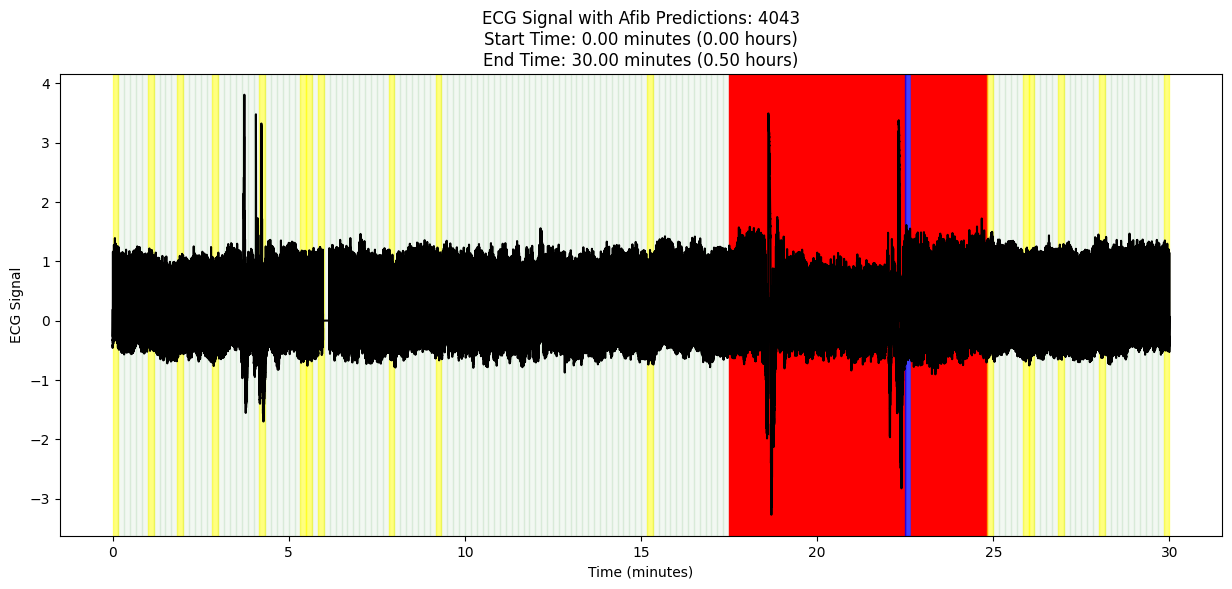

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


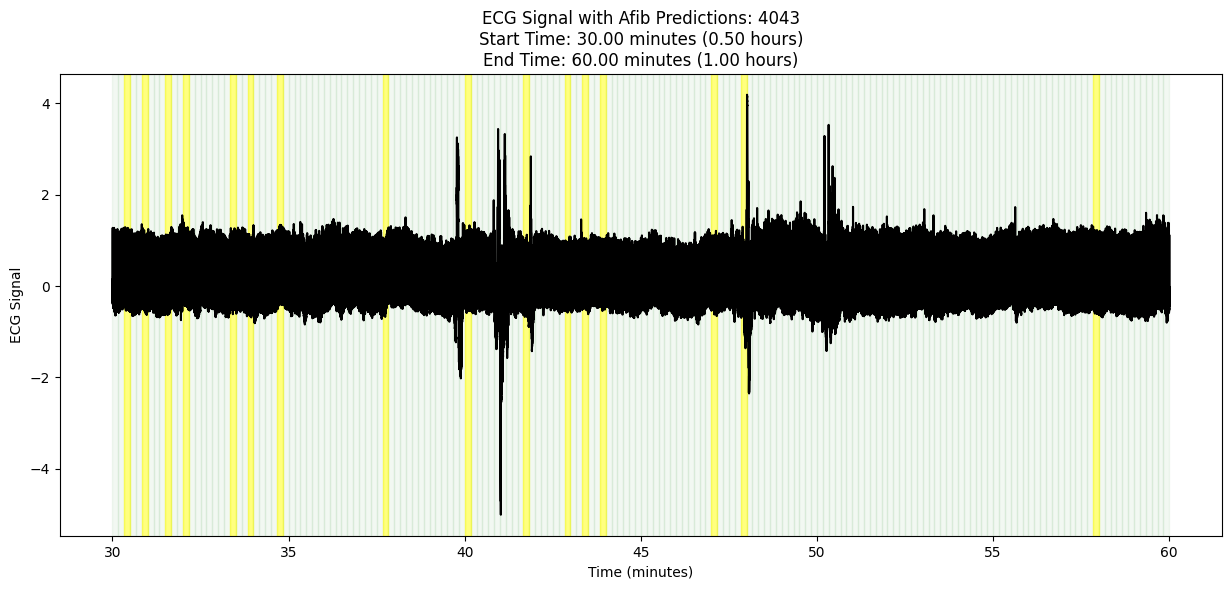

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


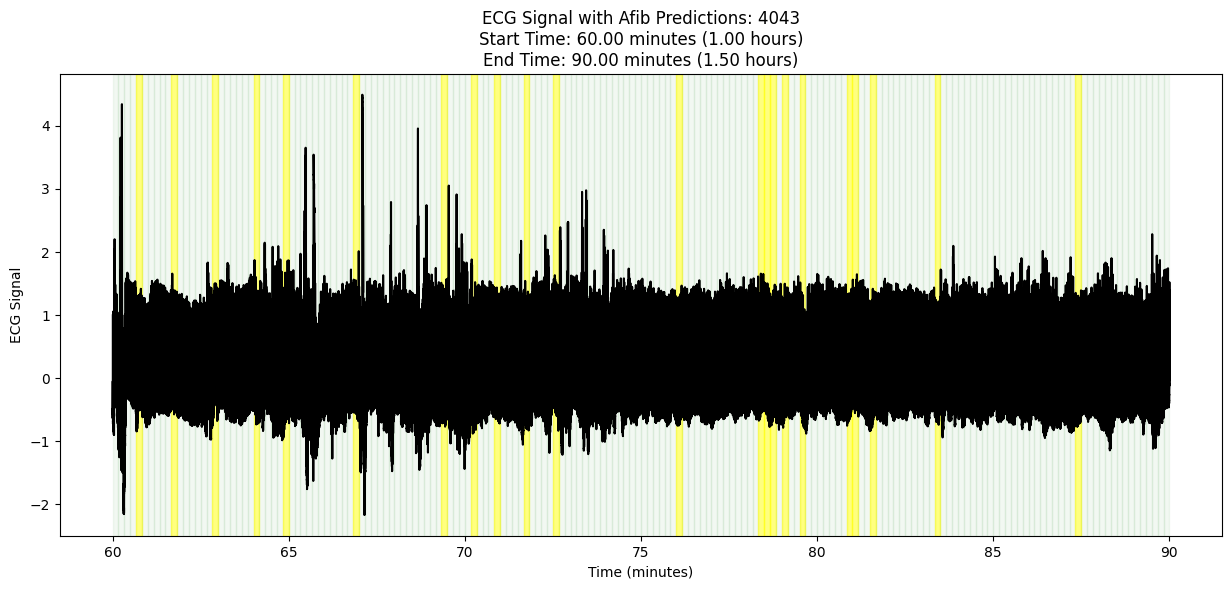

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


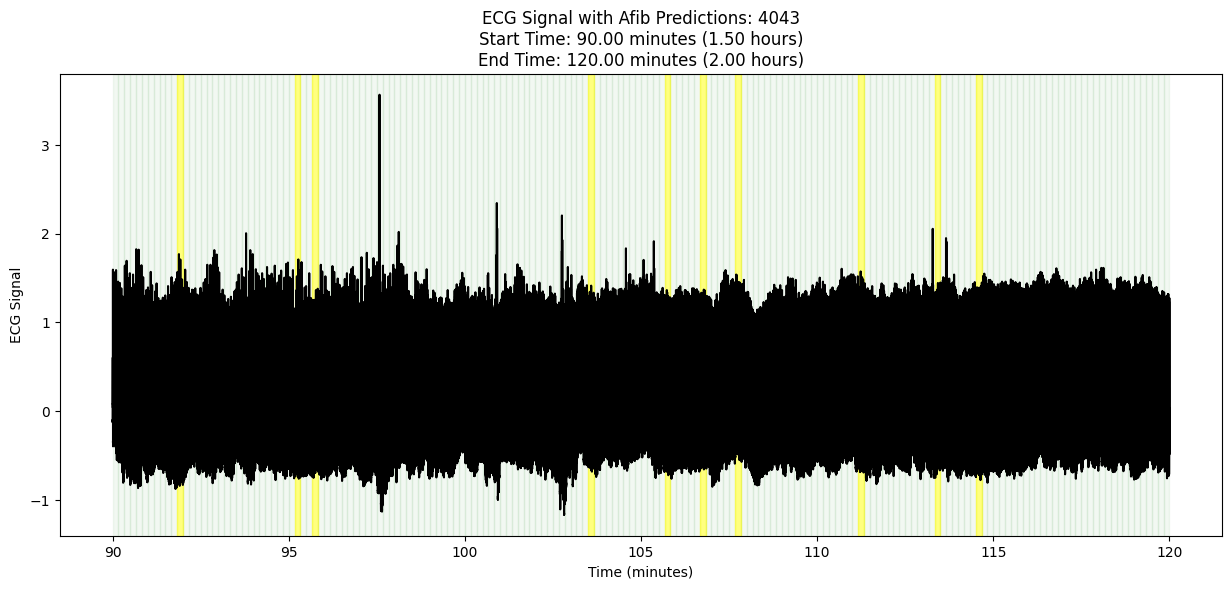

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


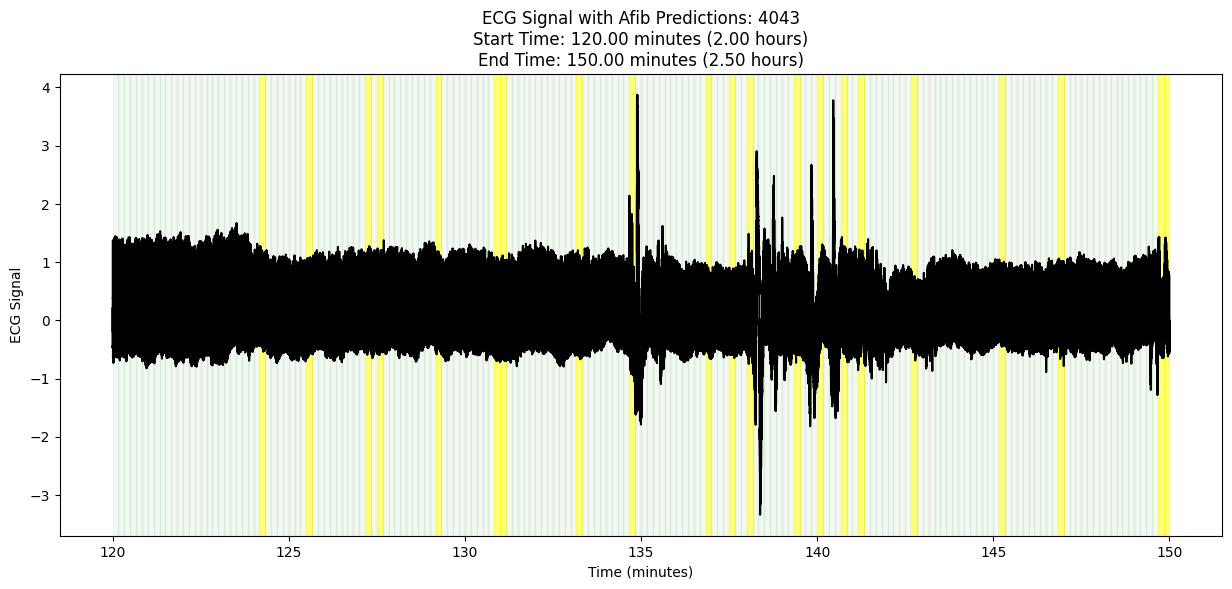

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


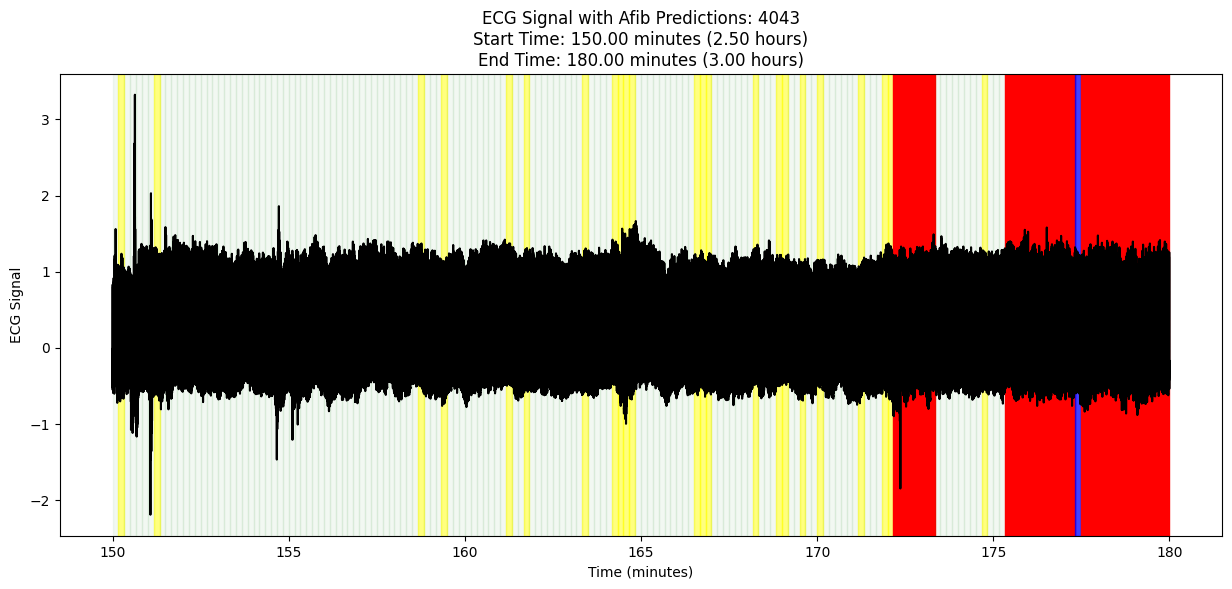

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


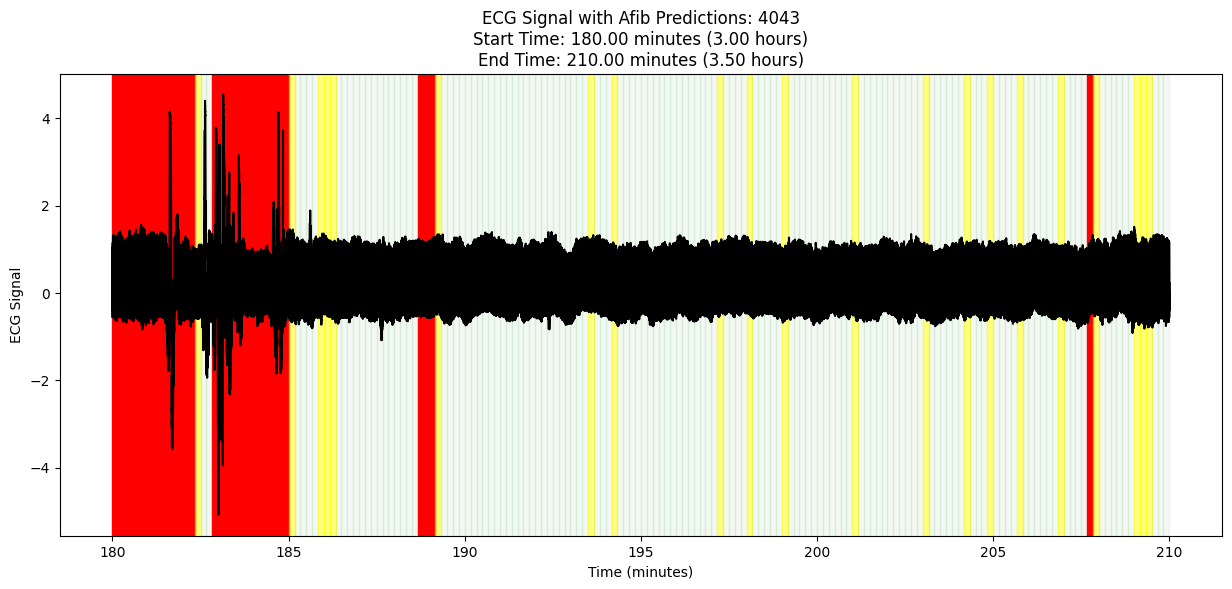

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


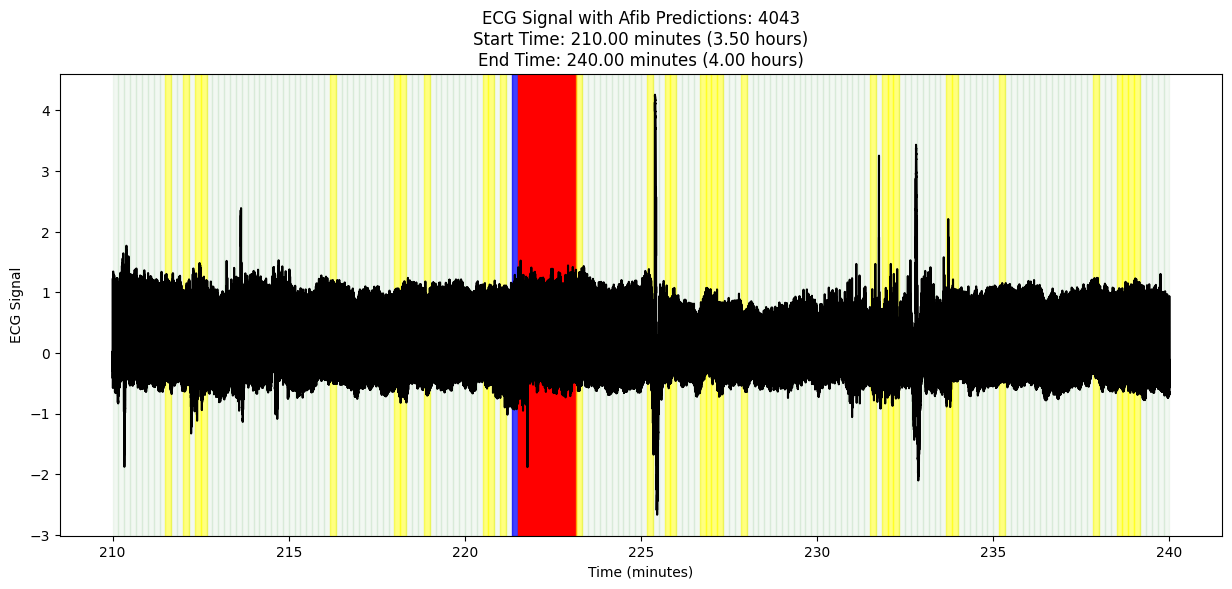

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


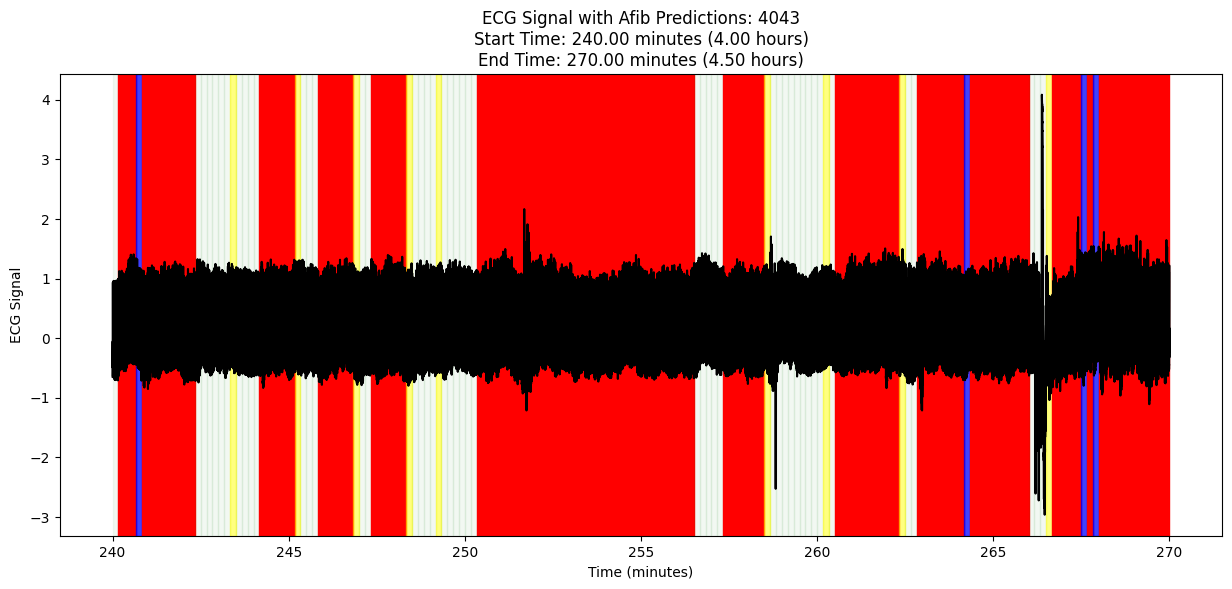

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


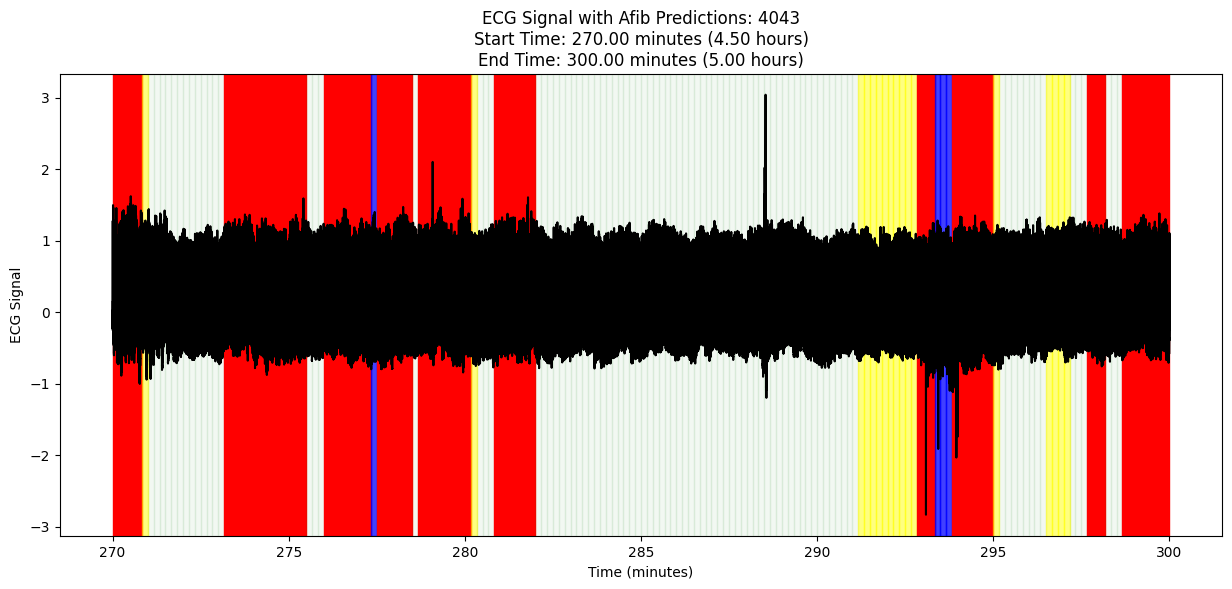

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


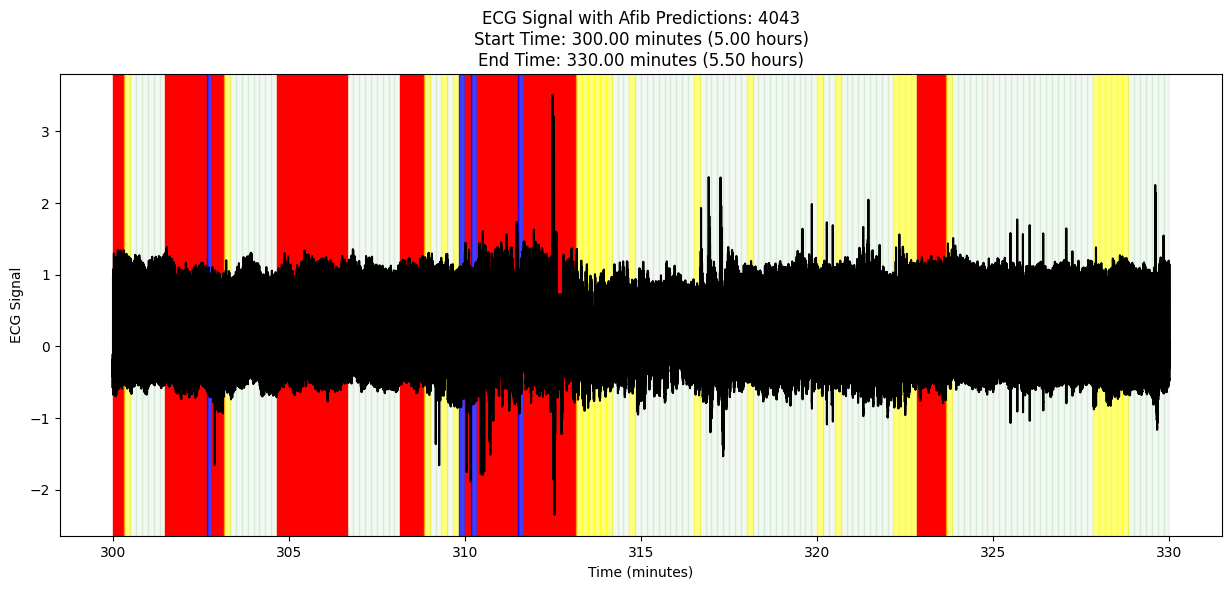

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


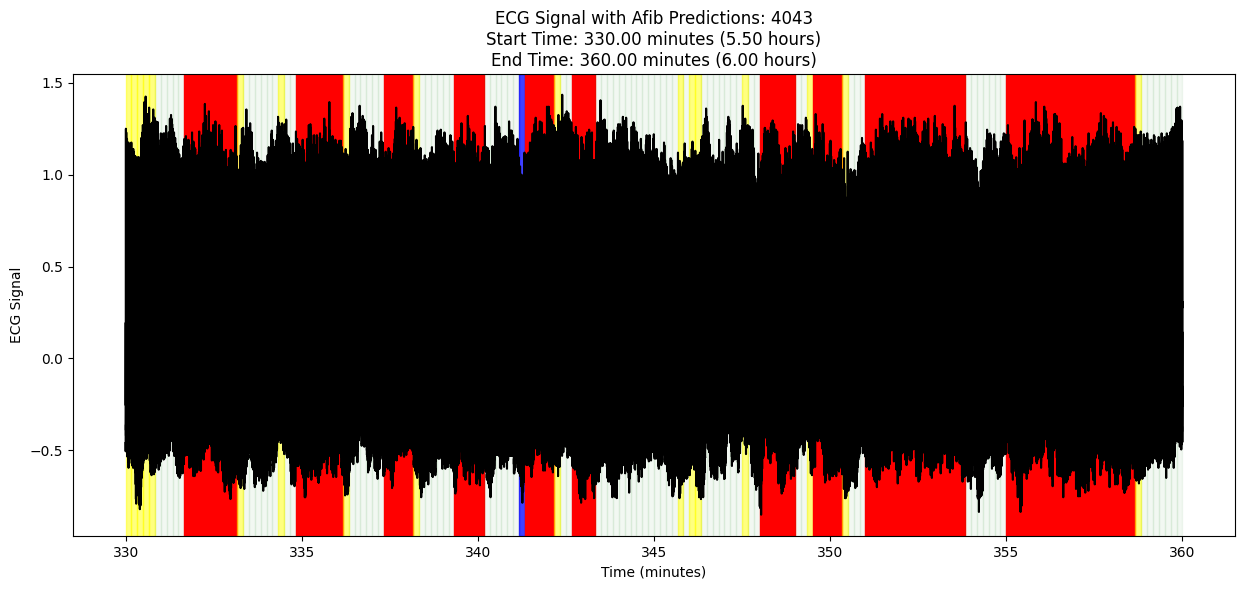

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


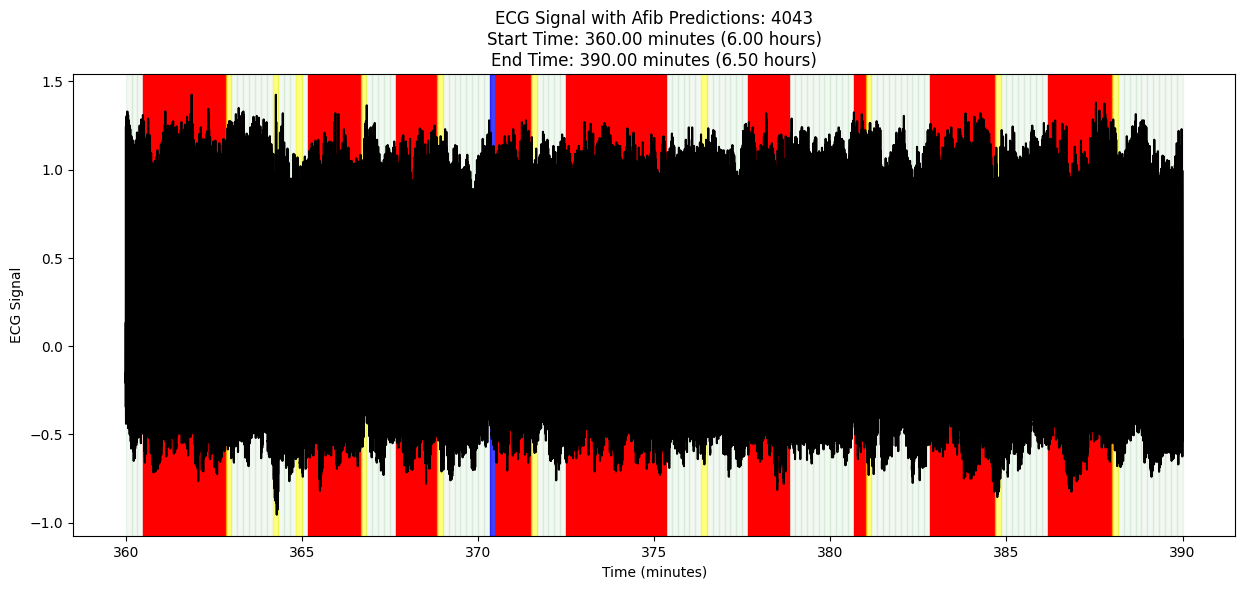

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


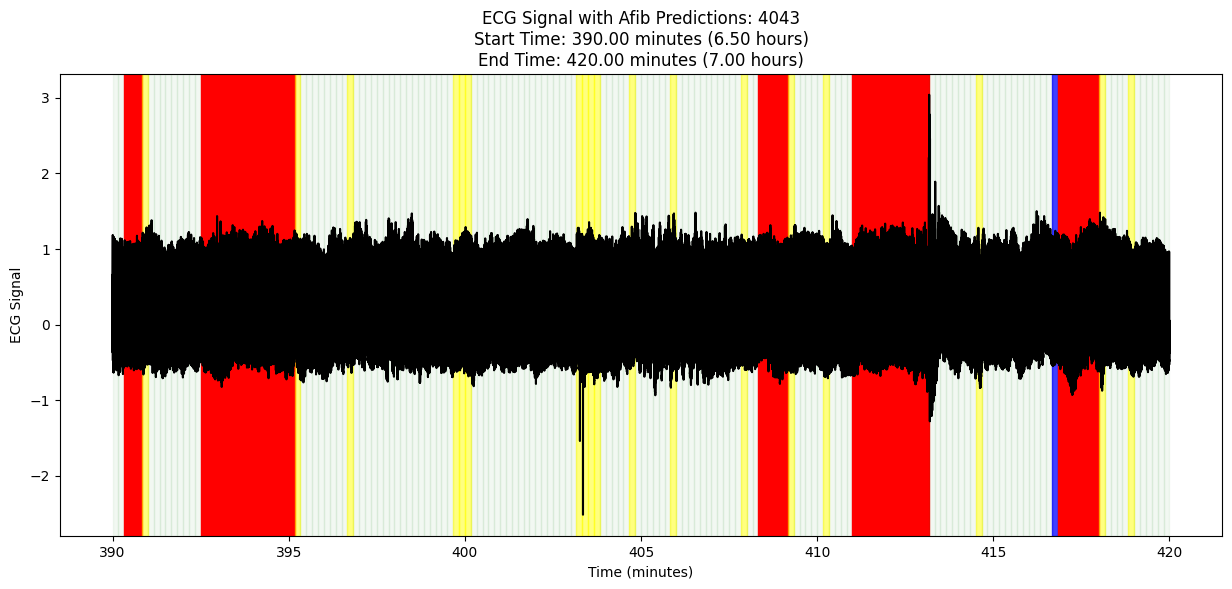

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


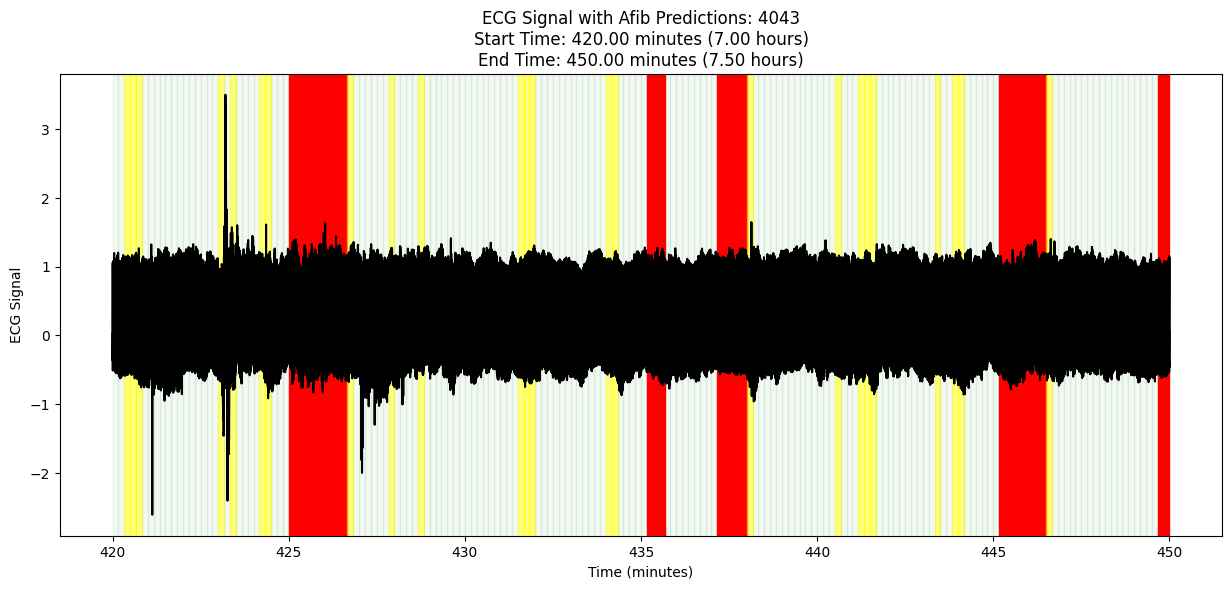

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


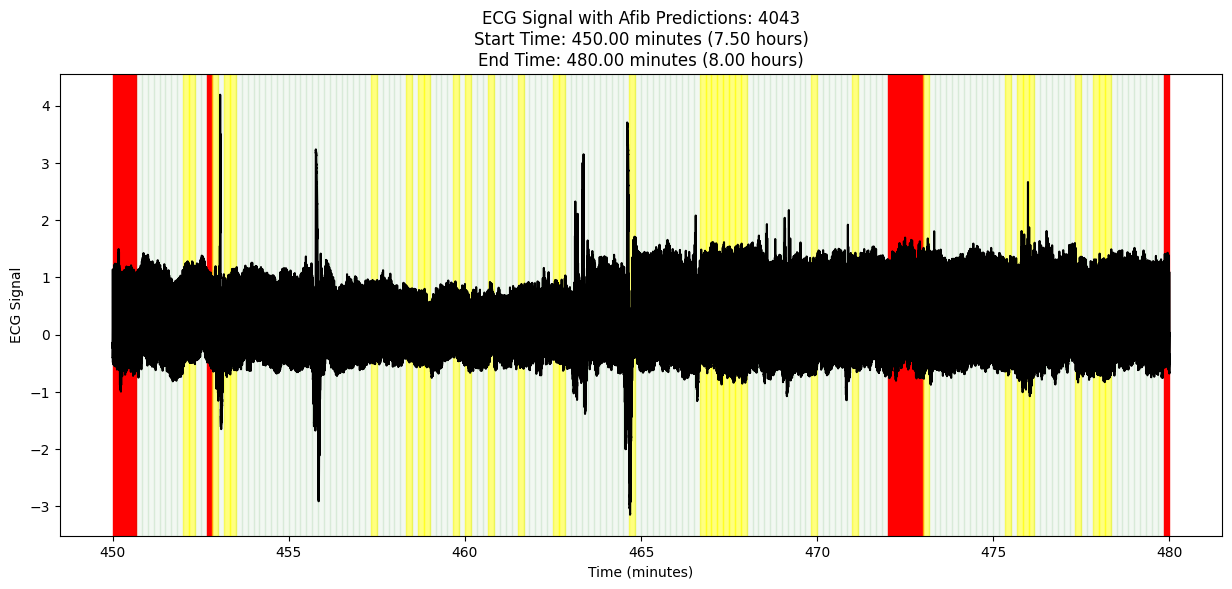

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


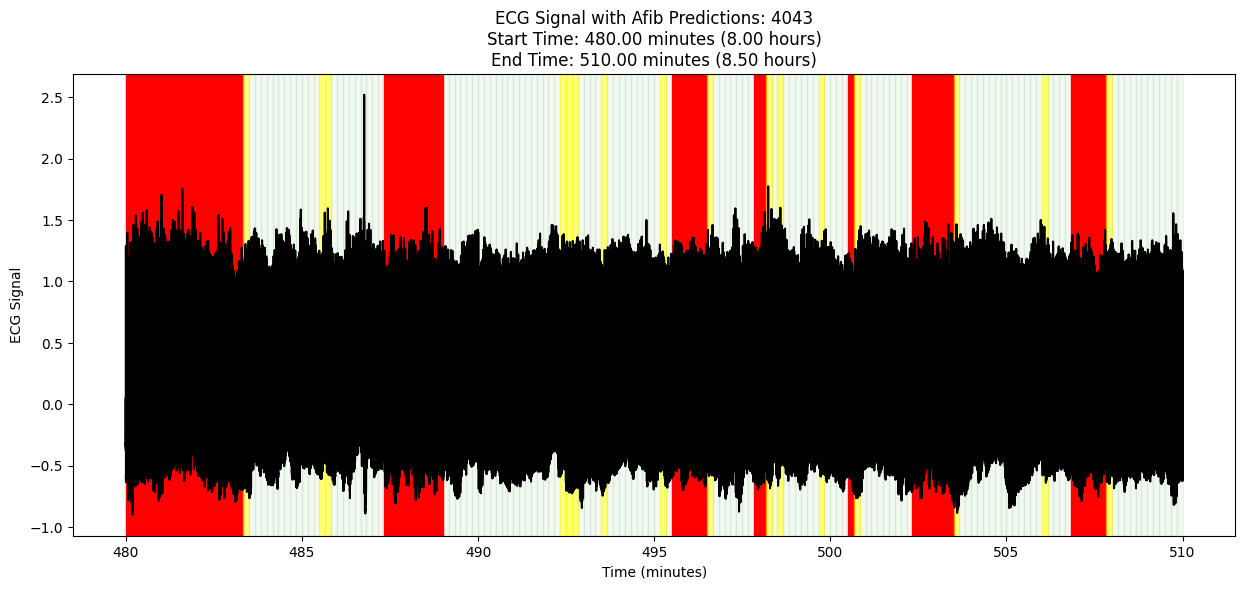

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


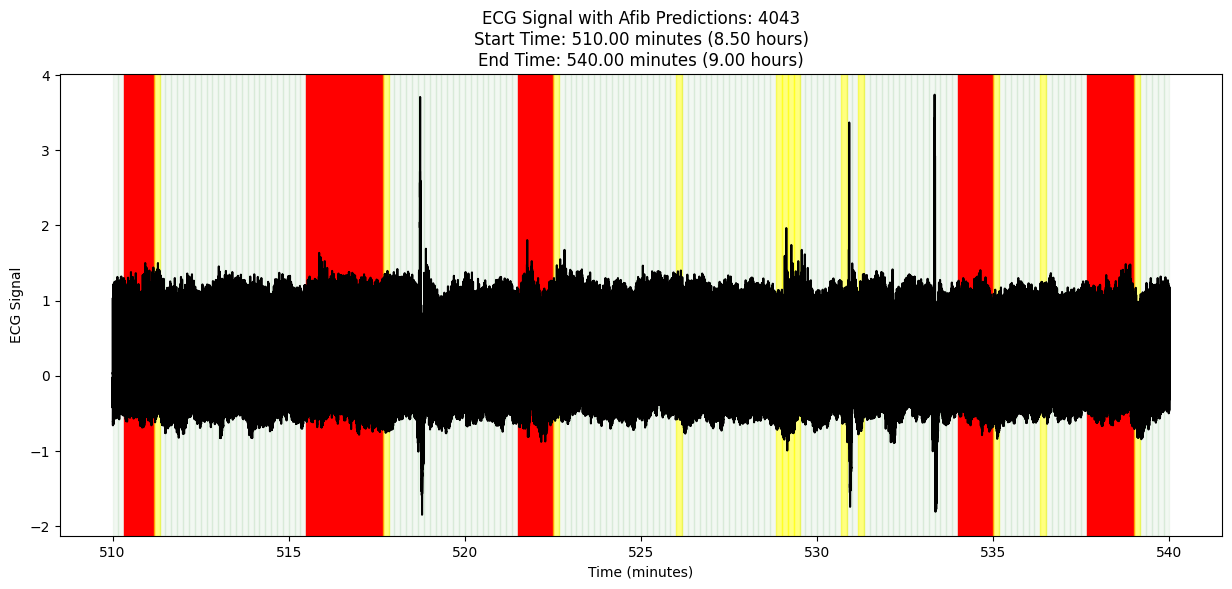

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


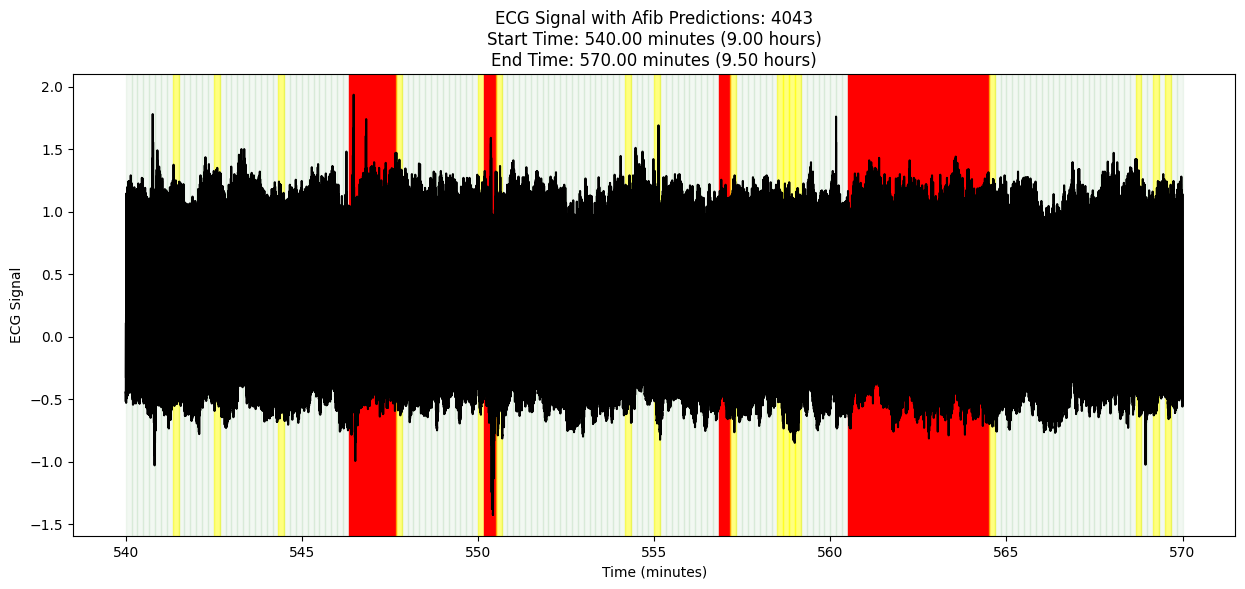

Predictions: 1189
[1 0 0 ... 1 1 0]
Actual AFIB: 795
[0 0 0 ... 0 0 0]


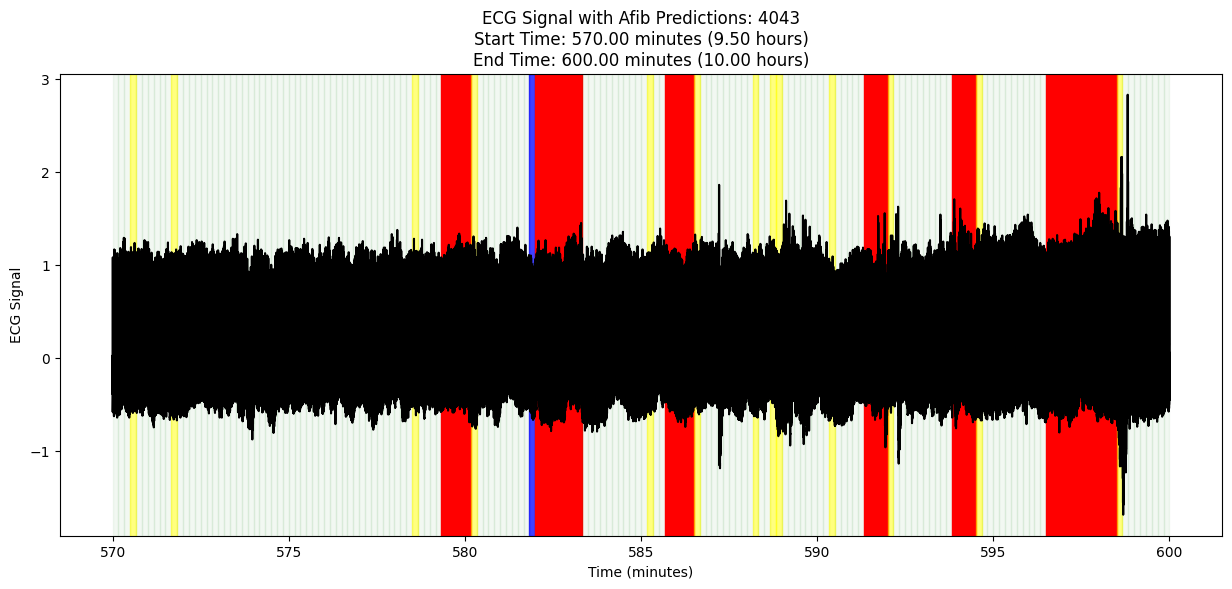

In [11]:
import wfdb
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np
import tensorflow as tf

record_name = "4043"

def load_model(model_path):
  model = tf.keras.models.load_model(model_path)
  return model

def load_data(file_path, specified_record):
  df = pd.read_csv(file_path)
  df['record_name'] = df['record_name'].astype(str)
  df = df[df['record_name'] == str(specified_record)]
  actual_afib_annotations = df['num_AFIB_annotations'].values  # Extract AFib annotations
  return df, actual_afib_annotations

def preprocess_data(df):
  # Check if the DataFrame is empty after filtering
  if df.empty:
      print(df)
      raise ValueError("No data left after filtering. Adjust the filter criteria.")

  # Normalize the data
  features = ['hrv_sdnn', 'hrv_rmssd', "hrv_mean", 'cv', "heart_rate_std", "heart_rate_mean", "sd1", "sd2"]
  scaler = StandardScaler()
  df[features] = scaler.fit_transform(df[features])

  # Add sampling_rate column
  df['sampling_rate'] = df['sampling_rate'].astype(int)

  return df, df[features], df[features].join(df['sampling_rate'])

# prediction method used for LSTM, CNN models
def predict(model, features):
  features = np.array(features).reshape((features.shape[0], 1, features.shape[1]))  # LSTM and CNN
  predictions = model.predict(features)
  return np.argmax(predictions, axis=1)

# Plot ECG signal with markers for Afib predictions
def plot_ecg_with_predictions(ecg_signal, predictions, actual_afib, sampling_rate, start_time, end_time):
  print("Predictions: " + str(np.count_nonzero(predictions)))
  print(predictions)
  print("Actual AFIB: " + str(np.count_nonzero(actual_afib)))
  print(actual_afib)
  plt.figure(figsize=(15, 6))

  # Calculate the indices corresponding to the start and end times
  start_index = int(start_time * sampling_rate)
  end_index = min(int(end_time * sampling_rate), len(ecg_signal))  # Ensure end_index does not exceed signal length

  # Extract the ECG signal and its corresponding time array for the specified interval
  ecg_interval = ecg_signal[start_index:end_index]
  time_interval = np.arange(start_time, start_time + len(ecg_interval) / sampling_rate,
                            1 / sampling_rate) / 60  # Convert to minutes

  # Plot ECG signal
  plt.plot(time_interval, ecg_interval, color='black')

  # Add markers for Afib predictions
  interval_length = 10  # 10-second intervals
  start_prediction_index = int(start_time / interval_length)
  end_prediction_index = int(end_time / interval_length)

  # Extract the relevant predictions for the interval
  relevant_predictions = predictions[start_prediction_index:end_prediction_index]
  relevant_actual_afib = actual_afib[start_prediction_index:end_prediction_index]

  for i, (pred, actual) in enumerate(zip(relevant_predictions, relevant_actual_afib)):
    interval_start = start_time + i * interval_length  # Interval start in seconds
    interval_end = start_time + (i + 1) * interval_length  # Interval end in seconds

    if interval_start >= end_time:  # Stop if interval exceeds signal length
      break

    interval_start_min = interval_start / 60  # Convert interval start to minutes
    interval_end_min = interval_end / 60  # Convert interval end to minutes

    if pred == 1:
      if actual == 1:
        plt.axvspan(interval_start_min, interval_end_min, color='red', alpha=1)  # Mark as red if actual and predict
      else:
        plt.axvspan(interval_start_min, interval_end_min, color='yellow', alpha=0.5)  # Mark as yellow only predict
    else:
      if actual == 1:
        plt.axvspan(interval_start_min, interval_end_min, color='blue', alpha=0.75)  # Mark as blue if actual
      else:
        plt.axvspan(interval_start_min, interval_end_min, color='green', alpha=0.05)  # Mark as green if normal

  # Convert start and end times to hours
  start_time_hours = start_time / 3600
  end_time_hours = end_time / 3600

  main_title = f"ECG Signal with Afib Predictions: {record_name}"
  subtitle1 = f"Start Time: {start_time / 60:.2f} minutes ({start_time_hours:.2f} hours)"
  subtitle2 = f"End Time: {end_time / 60:.2f} minutes ({end_time_hours:.2f} hours)"

  # Include start time in the title (converted to minutes)
  plt.xlabel('Time (minutes)')
  plt.ylabel('ECG Signal')
  plt.title(f'{main_title}\n{subtitle1}\n{subtitle2}')
  plt.show()

model_path = '/content/LSTM_model.keras'
model = load_model(model_path)

df, actual_afib_annotations = load_data('/content/afdb_data.csv', record_name)
df, features, features_sample = preprocess_data(df)

predictions = predict(model, features)



record_path = str("/content/files/0" + record_name)
# Load the ECG data
signals, fields = wfdb.rdsamp(record_path)  # Assuming you have the PhysioNet database downloaded
ecg_signal = signals[:, 0]  # Extract the first channel (ECG signal)
sampling_rate = int(features_sample["sampling_rate"].iloc[0])  # Sampling rate from the features DataFrame

# Define the time interval for plotting (30 minutes)
interval_length_minutes = 30
interval_length_seconds = interval_length_minutes * 60
total_duration_seconds = len(ecg_signal) / sampling_rate
num_intervals = int(total_duration_seconds / interval_length_seconds)

for i in range(num_intervals):
  start_time = i * interval_length_seconds
  end_time = (i + 1) * interval_length_seconds

  # Plot ECG with Afib predictions for each 30-minute interval
  plot_ecg_with_predictions(ecg_signal, predictions, actual_afib_annotations, sampling_rate, start_time, end_time)

1. Czerwony:
Oznacza przedziały czasowe, w których model przewidział AFib i rzeczywista adnotacja również potwierdza obecność AFib.
To oznacza poprawne pozytywne predykcje.


2. Żółty:
Oznacza przedziały, w których model przewidział AFib, ale rzeczywista adnotacja nie potwierdza AFib.
To są fałszywe pozytywy.


3. Niebieski:
Oznacza przedziały, w których rzeczywista adnotacja wskazuje AFib, ale model nie wykrył AFib.
To są fałszywe negatywy.


4. Zielony:
Oznacza przedziały, w których model nie przewidział AFib i rzeczywista adnotacja również nie wskazuje na obecność AFib.
To oznacza poprawne negatywne predykcje.